In [45]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import numpy as np
import sklearn, sklearn.model_selection
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');
import random
%matplotlib inline

In [46]:
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['']
    
parser = argparse.ArgumentParser()

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-nsamples', type=int, nargs='?',default=500, help='Number of samples for train')
parser.add_argument('-thing', default=False, action='store_true', help='Do the thing')


args = parser.parse_args()

In [47]:
args

Namespace(nsamples=500, seed=0, thing=False)

In [48]:
torch.manual_seed(args.seed);
random.seed(args.seed)

In [49]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [50]:
cuda = torch.cuda.is_available()

In [51]:
BATCH_SIZE = 64

In [52]:
from torch.utils import data
import os
import skimage, skimage.transform
from skimage.io import imread, imsave

In [53]:
from PIL import Image
import skimage.filters

In [59]:
class TNTDataset(data.Dataset):
    'Tumor-NoTumor Dataset loader for PyTorch'
    def __init__(self, tntpath, subset="train", transform=None, blur=0):
        self.tntpath = tntpath
        self.subset = subset
        self.datapath = self.tntpath + "/" + self.subset + "/"
        self.imgs = sorted(os.listdir(self.datapath + "/flair"))
        self.transform = transform
        self.blur = blur

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        # Select sample
        filename = self.imgs[index]
        
        flair = imread(self.datapath + "/flair/" + filename)
        flair = Image.fromarray(flair)
        if self.transform != None:
            flair = self.transform(flair)
            
#         t1 = imread(self.datapath + "/t1/" + filename)
#         t1 = Image.fromarray(t1)
#         if self.transform != None:
#             t1 = self.transform(t1)
            
        seg = imread(self.datapath + "/segmentation/" + filename)
        seg = ((seg >= 30))*256.
        
        if self.blur > 0:
            seg = skimage.filters.gaussian(seg, self.blur)
            seg = seg/seg.max()
            
        seg = (seg > 0)*1.
        
        seg = Image.fromarray(seg)
        if self.transform != None:
            seg = self.transform(seg)
        
        
        has_tumor = ("True" in filename)

        return (flair, flair, seg), has_tumor 

In [60]:
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()])

In [67]:
train = TNTDataset("/data/lisa/data/brats2013_tumor-notumor/", 
                   transform=mytransform,
                   blur=1)

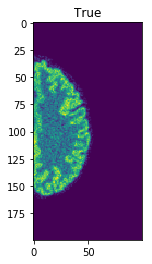

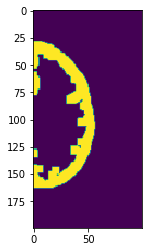

In [68]:
plt.imshow(train[5][0][0][0]);
plt.title(train[5][1]);
plt.show()
plt.imshow(train[5][0][2][0]);

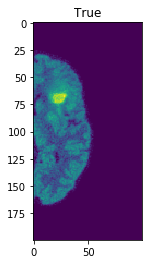

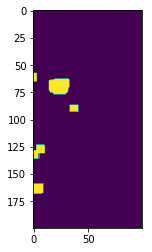

In [69]:
plt.imshow(train[250][0][0][0]);
plt.title(train[250][1]);
plt.show()
plt.imshow(train[250][0][2][0]);

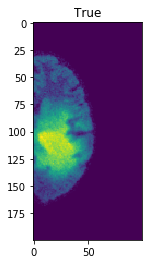

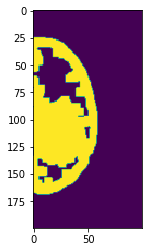

In [71]:
# def f(x):
#     plt.imshow(train[x][0][1][0]);
#     plt.title(train[x][1]);
#     plt.show()
#     plt.imshow(train[x][0][2][0]);

# interact(f, x=(0,len(train),1));

In [84]:
tosplit = np.asarray([("True" in name) for name in train.imgs])
idx = range(tosplit.shape[0])
train_idx, valid_idx = sklearn.model_selection.train_test_split(idx, stratify=tosplit, train_size=0.75, random_state=args.seed)


In [85]:
import collections
collections.Counter(tosplit)

Counter({False: 704, True: 1421})

In [86]:
print ("train_idx", len(train_idx))
print ("valid_idx", len(valid_idx))

train_idx 1593
valid_idx 532


In [87]:
#reduce samples
train_idx = train_idx[:args.nsamples]

In [88]:
print ("train_idx", len(train_idx))
print ("valid_idx", len(valid_idx))

train_idx 500
valid_idx 532


In [89]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx),
                                          num_workers=8)
valid_loader = torch.utils.data.DataLoader(dataset=train, batch_size=len(valid_idx), 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx),
                                          num_workers=8)

In [90]:
valid_data = list(valid_loader)
valid_x = Variable(valid_data[0][0][0]).cuda()
valid_y = valid_data[0][1].cuda()

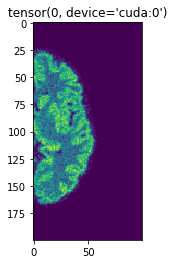

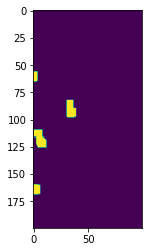

In [91]:
plt.imshow(valid_data[0][0][0][60][0]);
plt.title(valid_y[60]);
plt.show()
plt.imshow(valid_data[0][0][2][60][0]);


In [92]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),     
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(),
        )
        self.out = nn.Linear(440, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [93]:
cnn = CNN()
if cuda:
    cnn = cnn.cuda()

print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (out): Linear(in_features=440, out_features=2, bias=True)
)


In [94]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [34]:
use_gradmask = args.thing
stats = []

for epoch in range(200):
    batch_loss = []
    for step, (x, y) in enumerate(train_loader):
        
        b_x = Variable(x[0], requires_grad=True)
        b_y = Variable(y)
        seg_x = x[2]
        
        if cuda:
            b_x = b_x.cuda()
            b_y = b_y.cuda()
            seg_x = seg_x.cuda()

        cnn.train()
        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        
        if use_gradmask:
            input_grads = torch.autograd.grad(outputs=torch.abs(output).sum(), 
                                       inputs=b_x, 
                                       #retain_graph=True, 
                                       create_graph=True)[0]
            
            #only apply to positive examples
            input_grads = b_y.float().reshape(-1,1,1,1)*input_grads
            
            res = input_grads * (1-seg_x.float())
            loss = loss + loss*(res**2).sum()
            
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        batch_loss.append(loss.data[0])
        #print (loss)
    
    cnn.eval()
    test_output, last_layer = cnn(valid_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    #accuracy = float(sum(pred_y == valid_y.cuda())) / float(valid_y.size(0))
    auc = sklearn.metrics.roc_auc_score(valid_y, pred_y.cpu())
    stats.append({"seed":args.seed,
                  "epoch":epoch,
                  "trainloss":np.asarray(batch_loss).mean(),
                  "validauc": auc})
    print('Epoch: ', epoch, '| train loss: %.4f' % np.asarray(batch_loss).mean(), '| valid auc: %.2f' % auc)
                                        

/part/01/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  0 | train loss: 0.6199 | valid auc: 0.50
Epoch:  1 | train loss: 0.6232 | valid auc: 0.50
Epoch:  2 | train loss: 0.6154 | valid auc: 0.50
Epoch:  3 | train loss: 0.6066 | valid auc: 0.50
Epoch:  4 | train loss: 0.5933 | valid auc: 0.50
Epoch:  5 | train loss: 0.5744 | valid auc: 0.50
Epoch:  6 | train loss: 0.5504 | valid auc: 0.50
Epoch:  7 | train loss: 0.5264 | valid auc: 0.50
Epoch:  8 | train loss: 0.5095 | valid auc: 0.50
Epoch:  9 | train loss: 0.5066 | valid auc: 0.50
Epoch:  10 | train loss: 0.4980 | valid auc: 0.50
Epoch:  11 | train loss: 0.4955 | valid auc: 0.50
Epoch:  12 | train loss: 0.4939 | valid auc: 0.50
Epoch:  13 | train loss: 0.4845 | valid auc: 0.59
Epoch:  14 | train loss: 0.4820 | valid auc: 0.62
Epoch:  15 | train loss: 0.4779 | valid auc: 0.67
Epoch:  16 | train loss: 0.4797 | valid auc: 0.68
Epoch:  17 | train loss: 0.4792 | valid auc: 0.69
Epoch:  18 | train loss: 0.4715 | valid auc: 0.69
Epoch:  19 | train loss: 0.4645 | valid auc: 0.63
Epoch:  20

Process Process-1564:
Process Process-1563:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-1562:
  File "/Tmp/lisa/os_v5/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Tmp/lisa/os_v5/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/u/cohenjos/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
Process Process-1565:
Process Process-1561:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-1568:
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/Tmp/lisa/os_v5/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "<ipython-input-8-3903f5cea59c>", line 33, in __getitem__
    self.run()
    seg = seg/seg.max()
  File "/Tmp/lisa/os_v5/anaconda/lib/python2.7/multiprocessing/process.py", line 114, in run
  

RuntimeError: DataLoader worker (pid 23417) exited unexpectedly with exit code 1.

In [100]:
import pickle
#os.mkdir("stats")
pickle.dump(stats, open("stats/stats_"+ str(args.seed) + str(args.thing) + ".pkl","wb"))

In [ ]:
input_grads.shape

In [ ]:
b_y.float().unsqueeze(1).shape

In [ ]:
b_y.float()*input_grads

In [ ]:
filt = b_y.float().reshape(-1,1,1,1)*input_grads

In [ ]:
plt.imshow(seg_x[0][0].cpu().detach().numpy());

In [ ]:
plt.imshow(filt[0][0].cpu().detach().numpy());

In [ ]:
plt.imshow(b_x[5][0].cpu().detach().numpy())

In [ ]:
res = input_grads * (1-seg_x.float())
plt.imshow(res[5][0].cpu().detach().numpy())

In [ ]:
x, y = train[250]

In [ ]:
x[0].shape

In [ ]:
plt.imshow(x[0][0]);
plt.title(y);
plt.show()
plt.imshow(x[2][0]);

In [ ]:
x_var = Variable(x[0].unsqueeze(0).cuda(), requires_grad=True)
pred = cnn(x_var)

In [ ]:
test = torch.autograd.grad(outputs=torch.abs(pred[0]).sum(), 
                                       inputs=x_var, 
                                       retain_graph=True, 
                                       create_graph=True,
                                       grad_outputs=torch.FloatTensor([1]).cuda())

In [ ]:
input_grads = test[0][0][0].cpu().detach().numpy()

In [ ]:
plt.imshow(input_grads);

In [ ]:
# So much gradient!
plt.imshow(input_grads>0.0000001);

In [ ]:
plt.imshow(x[2][0])

In [ ]:
#these are the only allowed grads
masked_grads = input_grads*(x[2][0])
plt.imshow(masked_grads)

In [ ]:
#We can regularize to reduce this
masked_grads = input_grads*(1-x[2][0])
plt.imshow(masked_grads)

In [ ]:
import skimage.filters
enlarged_mask = skimage.filters.gaussian(x[2][0].numpy(),15)
enlarged_mask = enlarged_mask/enlarged_mask.max()
enlarged_mask.max()

In [ ]:
plt.imshow(enlarged_mask)

In [ ]:
#assuming the segmentations are sloppy we can enlarge the segmentations
masked_grads = input_grads*(1-enlarged_mask)
plt.imshow(masked_grads)

In [ ]:
#torch.save(cnn.state_dict(), "./classifier_model.pth")

In [ ]:
checkpoint = torch.load("./classifier_model.pth")
cnn.load_state_dict(checkpoint)

In [ ]:
# cnn.eval()
# test_output, last_layer = cnn(valid_x)
# pred_y = torch.max(test_output, 1)[1].data.squeeze()
# accuracy = float((pred_y == valid_y).sum()) / float(valid_y.size(0))
# print 'valid accuracy: %.2f' % accuracy